## Core Imports

In [1]:
# core libraries
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime as dt
import math
import seaborn as sns
import datetime
from functools import reduce

## Torch Imports

In [2]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [3]:
if torch.cuda.is_available():
    print(f"Primary GPU Available for training: {torch.cuda.get_device_name(0)}")

Primary GPU Available for training: GeForce GTX 1070 with Max-Q Design


In [4]:
os.getcwd()

'C:\\Users\\chris\\Documents\\GitHub\\arg\\notebooks'

In [5]:
os.chdir("..")

In [6]:
os.getcwd()

'C:\\Users\\chris\\Documents\\GitHub\\arg'

In [7]:
from config import ROOT_DIR, DATA_DIR, DATA_IN, DATA_OUT, FIGS_DIR, MODELS_DIR

In [8]:
import utils.models
from utils.data import get_df

## Load the Cleaned, Pre-processed Cn2 and Meteorological Data From Files

In [9]:
df = get_df()

In [10]:
df.head(1).T

,0
Timestamp,2020-01-01 00:10:00
Cn2,0.0
Air_Temperature,6.7
Relative_Humidity,57
Dew_Point_Temperature,-1.3
Wind_Speed,2.7
Wind_Direction,0
Wind_Run,1.61
Wind_Speed_Gust,6.7
Wind_Direction_Gust,0


### Prepare the Dataset for PyTorch Modeling

In [90]:
data = df.copy()[['Timestamp', 'Log_Cn2', 'Air_Temperature', 'Relative_Humidity',
       'Dew_Point_Temperature', 'Wind_Speed', 'Wind_Direction','Pressure', 'Solar_Radiation',
       'UV_Index', 'Air_Density', 'Sunrise_Time', 'Sunset_Time',
       'Air_Water_Temperature_Difference']]

In [91]:
data.head(30)

,Timestamp,Log_Cn2,Air_Temperature,Relative_Humidity,Dew_Point_Temperature,Wind_Speed,Wind_Direction,Pressure,Solar_Radiation,UV_Index,Air_Density,Sunrise_Time,Sunset_Time,Air_Water_Temperature_Difference
0,2020-01-01 00:10:00,-14.936967,6.7,57,-1.3,2.7,0,1008.1,0.0,0.0,1.2408,2020-01-01 07:25:00,2020-01-01 16:54:00,2.9
1,2020-01-01 00:20:00,-15.041384,6.7,59,-0.8,3.6,0,1008.1,0.0,0.0,1.2410,2020-01-01 07:25:00,2020-01-01 16:54:00,2.9
2,2020-01-01 00:30:00,-15.200632,6.6,60,-0.7,3.6,0,1008.2,0.0,0.0,1.2414,2020-01-01 07:25:00,2020-01-01 16:54:00,2.9
3,2020-01-01 00:40:00,-15.204989,6.5,60,-0.7,4.0,0,1008.2,0.0,0.0,1.2416,2020-01-01 07:25:00,2020-01-01 16:54:00,2.9
4,2020-01-01 00:50:00,-15.266281,6.4,59,-1.0,4.0,0,1008.1,0.0,0.0,1.2416,2020-01-01 07:25:00,2020-01-01 16:54:00,2.9
5,2020-01-01 01:00:00,-15.281905,6.4,60,-0.8,3.6,0,1008.2,0.0,0.0,1.2417,2020-01-01 07:25:00,2020-01-01 16:54:00,2.7
6,2020-01-01 01:10:00,-15.348402,6.3,59,-1.1,4.0,0,1008.3,0.0,0.0,1.2423,2020-01-01 07:25:00,2020-01-01 16:54:00,2.7
7,2020-01-01 01:20:00,-15.448489,6.4,57,-1.5,4.0,0,1008.7,0.0,0.0,1.2429,2020-01-01 07:25:00,2020-01-01 16:54:00,2.7
8,2020-01-01 01:30:00,-15.406138,6.3,57,-1.6,3.1,0,1008.9,0.0,0.0,1.2434,2020-01-01 07:25:00,2020-01-01 16:54:00,2.7
9,2020-01-01 01:40:00,-15.563186,6.3,57,-1.6,3.1,0,1008.8,0.0,0.0,1.2439,2020-01-01 07:25:00,2020-01-01 16:54:00,2.7


In [92]:
data = data.rename(columns={"Timestamp": "date"})

In [93]:
data.columns

Index(['date', 'Log_Cn2', 'Air_Temperature', 'Relative_Humidity',
       'Dew_Point_Temperature', 'Wind_Speed', 'Wind_Direction', 'Pressure',
       'Solar_Radiation', 'UV_Index', 'Air_Density', 'Sunrise_Time',
       'Sunset_Time', 'Air_Water_Temperature_Difference'],
      dtype='object')

In [94]:
data.Wind_Direction = data.Wind_Direction.astype(str)
data.Relative_Humidity = data.Relative_Humidity.astype(np.int64)

In [95]:
data.head(3).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              3 non-null      datetime64[ns]
 1   Log_Cn2                           3 non-null      float64       
 2   Air_Temperature                   3 non-null      float64       
 3   Relative_Humidity                 3 non-null      int64         
 4   Dew_Point_Temperature             3 non-null      float64       
 5   Wind_Speed                        3 non-null      float64       
 6   Wind_Direction                    3 non-null      object        
 7   Pressure                          3 non-null      float64       
 8   Solar_Radiation                   3 non-null      float64       
 9   UV_Index                          3 non-null      float64       
 10  Air_Density                       3 non-null      floa

In [96]:
#data['time_idx'] = pd.to_datetime(data['date']).astype(np.int64)/600000000000 # record every 10 minutes, can be adjusted for new time steps
#data['time_idx'] -= data['time_idx'].min()
#data['time_idx'] = data['time_idx'].astype(np.int64) # interestingly, it is essential that the dtype of the time index be a 64 bit integer
data['time_idx'] = pd.Series(list(data.reset_index().index.values.astype(np.int64)))

#### Validate the time_idx as monotonically increasing

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36769 entries, 0 to 36768
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              36769 non-null  datetime64[ns]
 1   Log_Cn2                           36769 non-null  float64       
 2   Air_Temperature                   36769 non-null  float64       
 3   Relative_Humidity                 36769 non-null  int64         
 4   Dew_Point_Temperature             36769 non-null  float64       
 5   Wind_Speed                        36769 non-null  float64       
 6   Wind_Direction                    36769 non-null  object        
 7   Pressure                          36769 non-null  float64       
 8   Solar_Radiation                   36769 non-null  float64       
 9   UV_Index                          36769 non-null  float64       
 10  Air_Density                       36769 non-nu

In [98]:
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings, 

In [99]:
data["group"] = 0

In [100]:
data = data.head(9000)

### Create TimeSeriesDataSet

In [76]:
max_prediction_length = 60
max_encoder_length = 360
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Log_Cn2",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    #static_categoricals=["group"],
    #static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["month"],
    #variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "Sunrise_Time", "Sunset_Time",         
                              "Air_Temperature",
        "Relative_Humidity",
        "Dew_Point_Temperature",
        "Wind_Speed",
        "Pressure",
        "Solar_Radiation",
        "UV_Index",
        "Air_Density",
        "Air_Water_Temperature_Difference"    ],
    time_varying_unknown_categoricals=["Wind_Direction"],
    time_varying_unknown_reals=[
        "Log_Cn2", 
    ],
    #allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

### PyTorch Forecasting

#### Find the predicted optimal learning rate

In [45]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 29.3k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 173   
3  | prescalers                         | ModuleDict                      | 272   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 10.7 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

suggested learning rate: 1.5488166189124817e-05


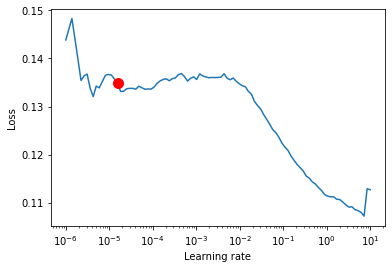

In [46]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

#### Train the model

In [77]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.05,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.2,
    hidden_continuous_size=16,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 118.8k


In [78]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 129   
3  | prescalers                         | ModuleDict                      | 544   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 30.9 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 27.9 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm 

Global seed set to 42


Epoch 0:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 30/31 [00:22<00:00,  1.40it/s, loss=0.148, v_num=12, train_loss_step=0.145]
Validating: 0it [00:00, ?it/s]
Epoch 1:  97%|█████████████████████████████████████████████████████████████████████████▌  | 30/31 [00:22<00:00,  1.38it/s, loss=0.116, v_num=12, train_loss_step=0.104, val_loss=0.153, train_loss_epoch=0.185]
Validating: 0it [00:00, ?it/s]
Epoch 2:  97%|██████████████████████████████████████████████████████████████████████▋  | 30/31 [00:22<00:00,  1.41it/s, loss=0.0882, v_num=12, train_loss_step=0.0787, val_loss=0.0839, train_loss_epoch=0.121]
Validating: 0it [00:00, ?it/s]
Epoch 3:  97%|█████████████████████████████████████████████████████████████████████▋  | 30/31 [00:22<00:00,  1.41it/s, loss=0.0747, v_num=12, train_loss_step=0.0693, val_loss=0.0676, train_loss_epoch=0.0917]
Validating: 0it [00:00, ?it/s]
Epoch 4:  97%|██████████████████████████████

Epoch 12:  97%|████████████████████████████████████████████████████████████████████▋  | 30/31 [00:22<00:00,  1.41it/s, loss=0.0416, v_num=12, train_loss_step=0.0365, val_loss=0.0824, train_loss_epoch=0.0426]
Validating: 0it [00:00, ?it/s]
Epoch 13:  97%|████████████████████████████████████████████████████████████████████▋  | 30/31 [00:22<00:00,  1.37it/s, loss=0.0365, v_num=12, train_loss_step=0.0345, val_loss=0.0755, train_loss_epoch=0.0418]
Validating: 0it [00:00, ?it/s]
Epoch 14:  97%|█████████████████████████████████████████████████████████████████████▋  | 30/31 [00:22<00:00,  1.40it/s, loss=0.0355, v_num=12, train_loss_step=0.0361, val_loss=0.0788, train_loss_epoch=0.037]
Validating: 0it [00:00, ?it/s]
Epoch 15:  97%|█████████████████████████████████████████████████████████████████████▋  | 30/31 [00:22<00:00,  1.40it/s, loss=0.0354, v_num=12, train_loss_step=0.0339, val_loss=0.090, train_loss_epoch=0.0357]
Validating: 0it [00:00, ?it/s]
Epoch 16:  97%|█████████████████████████████

In [79]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.2546)

In [80]:
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)

In [85]:
len(raw_predictions)

7

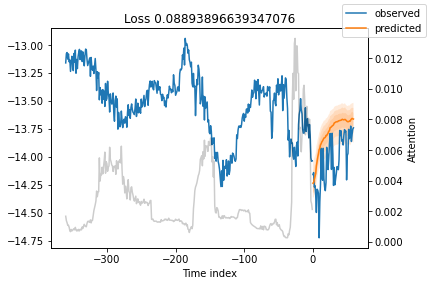

In [87]:
tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

## Longer prediction window

### Create TimeSeriesDataSet

In [101]:
max_prediction_length = 360
max_encoder_length = 360
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Log_Cn2",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    #static_categoricals=["group"],
    #static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["month"],
    #variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "Sunrise_Time", "Sunset_Time",         
                              "Air_Temperature",
        "Relative_Humidity",
        "Dew_Point_Temperature",
        "Wind_Speed",
        "Pressure",
        "Solar_Radiation",
        "UV_Index",
        "Air_Density",
        "Air_Water_Temperature_Difference"    ],
    time_varying_unknown_categoricals=["Wind_Direction"],
    time_varying_unknown_reals=[
        "Log_Cn2", 
    ],
    #allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

### PyTorch Forecasting

#### Train the model

In [102]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.05,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.2,
    hidden_continuous_size=16,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 118.8k


In [103]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 137   
3  | prescalers                         | ModuleDict                      | 544   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 30.9 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 27.9 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm 

Global seed set to 42


Epoch 0:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 30/31 [00:32<00:01,  1.05s/it, loss=0.172, v_num=13, train_loss_step=0.156]
Validating: 0it [00:00, ?it/s]
Epoch 1:  97%|█████████████████████████████████████████████████████████████████████████▌  | 30/31 [00:32<00:01,  1.05s/it, loss=0.136, v_num=13, train_loss_step=0.129, val_loss=0.168, train_loss_epoch=0.215]
Validating: 0it [00:00, ?it/s]
Epoch 2:  97%|████████████████████████████████████████████████████████████████████████▌  | 30/31 [00:32<00:01,  1.05s/it, loss=0.106, v_num=13, train_loss_step=0.0985, val_loss=0.118, train_loss_epoch=0.141]
Validating: 0it [00:00, ?it/s]
Epoch 3:  97%|███████████████████████████████████████████████████████████████████████▌  | 30/31 [00:33<00:01,  1.09s/it, loss=0.0928, v_num=13, train_loss_step=0.0861, val_loss=0.111, train_loss_epoch=0.109]
Validating: 0it [00:00, ?it/s]
Epoch 4:  97%|██████████████████████████████

Epoch 12:  97%|██████████████████████████████████████████████████████████████████████▋  | 30/31 [00:32<00:01,  1.05s/it, loss=0.0595, v_num=13, train_loss_step=0.058, val_loss=0.114, train_loss_epoch=0.0607]
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████| 31/31 [00:34<00:00,  1.08s/it, loss=0.0595, v_num=13, train_loss_step=0.058, val_loss=0.113, train_loss_epoch=0.0607]


In [104]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.4306)

In [105]:
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)

In [106]:
len(raw_predictions)

7

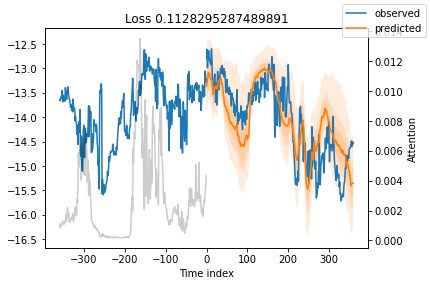

In [107]:
tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

### Create a limited, masked plot for basic vizualization

In [ ]:
df_plot_mask = ((df['Timestamp'] >= dt.datetime(2020, 1, 1, 0, 0))&(df['Timestamp'] <= dt.datetime(2020, 7, 17, 0, 0)))
df_plot = df.loc[df_plot_mask]

#%% define the training and validation masks and data sets
# Time series plot of one day
df_test_mask = (df_plot['Timestamp'] <= dt.datetime(2020, 6, 15, 19, 20))
df_plot_test = df_plot.loc[df_test_mask]

df_val_mask = (df_plot['Timestamp'] >= dt.datetime(2020, 6, 15, 19, 30))
df_plot_val = df_plot.loc[df_val_mask]

#### Run a basic plot

In [ ]:
from utils.figures import plotYearlyJointKDE

In [ ]:
plotYearlyJointKDE(df,'Air_Water_Temperature_Difference','Log_Cn2')